In [12]:
# 
# Author: Tianran Zhang
# Contact: tianran.zhang@kcl.ac.uk 
# Date: 2017-01-24 17:11:29
# Last Modified by:  Tianran Zhang 
# Last Modified time: 2020-08-27 15:04:48

                                  #########       
                                 ##       ###     
                        #########      ######     
                    ####             ##           
                  ###                 ##          
               ###              ########          
            ####    #######    ##                 
       #####   #####     ##  ###                  
       ########          ########    
        
%matplotlib inline

import os
import sys
import glob
import datetime
import numpy as np
from netCDF4 import Dataset,num2date, date2num
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange

dir_data     = 'C:/Users/Tianr/Dropbox/Research/VIIRS/Paper_FireEmission/productCheck/public/'
dir_external = 'C:/Users/Tianr/Dropbox/Research/VIIRS/Paper_FireEmission/productCheck/external_input/'
dir_fig      = os.getcwd()


In [20]:
def readFRE(nc_file_name):
    dataset = Dataset('%s'%(nc_file_name),'r') 
    FRE = dataset.variables['FRE'][:,:,:]
    FRE[np.where(np.isinf(FRE))]=0.0
    FRE[np.where(np.isnan(FRE))]=0.0
    latitude = dataset.variables['lat'][:]
    longitude = dataset.variables['lon'][:]
    times = dataset.variables['time']
    FREdates = num2date(times[:], units=times.units,calendar=times.calendar)
    dataset.close() 
    return FRE,FREdates,latitude,longitude

def read_month_harvestmap(read_month):
    harvest_map_path = os.path.join(dir_external,'MIRCA2000_EChina_CropRotationMap_2000_01degree.nc')
    dataset = Dataset(harvest_map_path,'r') 
    month_name = str(read_month)[4:]
    ###condition for winter season, see paper Section 5.1
    if ((month_name == '12') or (month_name =='01')or (month_name =='11')):
        month_name = '10'
    harvestArr = dataset.variables[month_name][:,:]
    dataset.close()    
    wheatArr = np.zeros(harvestArr.shape)
    cornArr  = np.zeros(harvestArr.shape)
    riceArr  = np.zeros(harvestArr.shape)
    wheatArr[harvestArr==1] = 1
    cornArr[harvestArr==2]  = 1
    riceArr[harvestArr==3]  = 1
    return wheatArr,cornArr,riceArr


In [21]:
#### read data

nc_file_list = glob.glob(os.path.join(dir_data,'*.nc'))

startday = datetime.datetime(2012,1,1)
endday   = datetime.datetime(2016,1,1)
interval = datetime.timedelta(days=1)

FREdatelist = np.arange(startday,endday,interval).astype(datetime.datetime)
ndate = len(FREdatelist)
FREdaysumlist   = np.zeros(ndate)
FREdaywheatlist = np.zeros(ndate)
FREdaycornlist  = np.zeros(ndate)
FREdayricelist  = np.zeros(ndate)

for ind,nc_file_name in enumerate(nc_file_list):
    read_month = nc_file_name.split('_')[5]
#     print (ind, 'opening file', read_month)
    wheatArr,cornArr,riceArr = read_month_harvestmap(read_month)
    FRE,FREdates,_,_ = readFRE(nc_file_name)
    FREday = np.zeros(FREdates.shape[0])
    for jnd,jdate in enumerate(FREdates):
        inddate = np.where(FREdatelist==jdate)[0][0]
        dayFREArr = FRE[jnd,:,:]
        FREdaysumlist[inddate]   = np.mean(dayFREArr)
        FREdaywheatlist[inddate] = np.mean(dayFREArr*wheatArr)
        FREdaycornlist[inddate]  = np.mean(dayFREArr*cornArr)
        FREdayricelist[inddate]  = np.mean(dayFREArr*riceArr)

C:\Users\tianr\AppData\Local\conda\conda\envs\geoprocess\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if __name__ == '__main__':


In [22]:
### check data

totalsum = np.sum(FREdaysumlist)
FREdaycroplist = [FREdaywheatlist,FREdaycornlist,FREdayricelist]
for icroplist in FREdaycroplist:
    breaksum = np.sum(icroplist)
    print (breaksum/totalsum)

0.6392649487628195
0.17050569182821512
0.18474422431771742


2012 Wheat 36.702609729448426 0.7089876239578026
2012 Corn 8.099699811177526 0.15646263211879013
2012 Rice 6.965321500043512 0.13454974392340738
2013 Wheat 32.93677361647442 0.5951598463973253
2013 Corn 8.874421811438294 0.1603587401626634
2013 Rice 13.52985927503848 0.24448141344001106
2014 Wheat 30.83070932909496 0.6495847864211809
2014 Corn 8.16853480337332 0.17210619058367943
2014 Rice 8.462934744831967 0.1783090229951398
2015 Wheat 17.444368034085052 0.6042265057622871
2015 Corn 6.307662786203233 0.21848066019860776
2015 Rice 5.118546467739461 0.1772928340391051


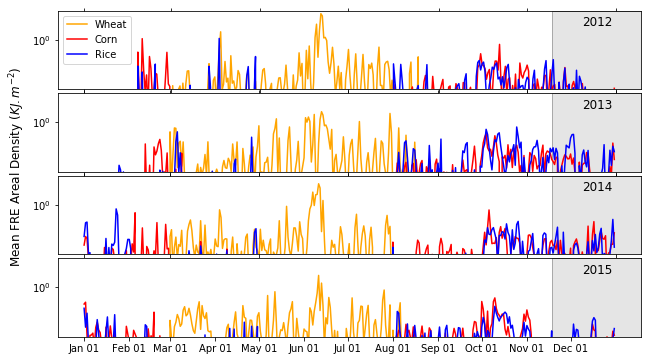

In [26]:
FREdaycroplist = [FREdaywheatlist,FREdaycornlist,FREdayricelist]
croplist       = ['Wheat','Corn','Rice']
colourlist     = ['orange','r','b']
symbollist     = ['^','.','+']

xS = 0.9
yS = 0.8
ymin = 0.02
ymax = 10
    
legendsize = 10
fontsize = 12
dpi      = 150
fig,axes = plt.subplots(figsize = (10,6),nrows=4)

for ind,ax in enumerate(axes.flat):
    year = 2012+ind
    ia = np.where(FREdatelist==datetime.datetime(year,1,1))[0][0]
    ib = np.where(FREdatelist==datetime.datetime(year,12,31))[0][0]+1
    for i in np.arange(3):
        xlist = np.array(FREdatelist[ia:ib])
        ylist = np.array(FREdaycroplist[i][ia:ib])*1000 # MJ to KJ
        condition = (ylist>0)
        ax.plot(xlist,ylist,'-',color=colourlist[i],label = croplist[i])
        print (year,croplist[i],np.sum(ylist),np.sum(ylist)/1000/np.sum([FREdaycroplist[ss][ia:ib] for ss in np.arange(3)])) 
    if ind!=3:
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
    if ind == 0:
        ax.legend(numpoints=1,prop={'size':legendsize})
    ax.set_yscale('log')
    ax.annotate(year, xy=(xS,yS),xycoords='axes fraction',fontsize=fontsize,color='k')
    ax.set_ylim(ymin,ymax)
    xmin,xmax = ax.get_xlim()
    ix = np.where(FREdatelist==datetime.datetime(2012,11,1))[0][0]
    iy = np.where(FREdatelist==datetime.datetime(2012,12,31))[0][0]
    xstart = (xmax-xmin)/360*ix+xmin
    xdelta = (xmax-xmin)/360*(iy-ix)
    ax.add_patch(matplotlib.patches.Rectangle((xstart, ymin),xdelta,ymax-ymin,
                                              edgecolor='k',facecolor="#aaaaaa",alpha=0.3))
    
ticklist = []
for ind,idate in enumerate(xlist):
    if idate.day==1:
        ticklist.append(ind)
ax.set_xticks(xlist[ticklist])
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

fig.subplots_adjust(left = 0.09,hspace=0.05)
fig.text(0.02,0.3,'Mean FRE Areal Density ($KJ. m^{-2}$)',rotation = 90,fontsize = fontsize)
os.chdir(dir_fig)
fig.savefig('Figure5.png',dpi = dpi)
plt.show()